## Importation des packages

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

## Importation des données

In [2]:
df1 = pd.DataFrame(pd.read_csv("FAOSTAT_pop_18_08.csv"))
piv1=df1.pivot_table(index=['Zone'],columns='Année',values='Valeur').reset_index()#utiliser des éléments présentes dans colonne "Année" comme noms de colonnes 
piv1['croissance_population %']=(piv1[2018]-piv1[2008])/piv1[2008]*100
piv1=piv1[['Zone','croissance_population %']].copy()

In [3]:
df2 = pd.DataFrame(pd.read_csv("FAOSTAT2018.csv"))
piv2=df2.pivot_table(index=['Zone','Produit'],columns='Élément',values='Valeur').reset_index()#utiliser des éléments présentes dans colonne "Élément" comme noms de colonnes
piv2=piv2.groupby('Zone')[['Disponibilité alimentaire (Kcal/personne/jour)','Disponibilité de protéines en quantité (g/personne/jour)']].sum().reset_index()
piv2['Disponibilité alimentaire (Kcal/personne)']=piv2['Disponibilité alimentaire (Kcal/personne/jour)']*365
piv2['Disponibilité de protéines en quantité (g/personne)']=piv2['Disponibilité de protéines en quantité (g/personne/jour)']*365
piv3=df2.pivot_table(index=['Zone','Produit'],columns='Élément',values='Valeur').reset_index()##
df_pro=piv3[piv3['Produit']=="Produits Animaux"].copy()
df_pro.rename(columns={'Disponibilité de protéines en quantité (g/personne/jour)':'protéines_animale'}, inplace=True)
df_pro=df_pro[['Zone','protéines_animale']].copy()
df=pd.merge(piv2,df_pro,on='Zone')
df['proportion_protéines_animal %']=df['protéines_animale']/df['Disponibilité de protéines en quantité (g/personne/jour)']*100
df=df[['Zone','Disponibilité alimentaire (Kcal/personne)','Disponibilité de protéines en quantité (g/personne)','proportion_protéines_animal %']]
df=df.merge(piv1,on='Zone')


In [4]:
df3 = pd.DataFrame(pd.read_csv("FAOSTAT_pib_sta_2018.csv"))
piv4=df3.pivot_table(index=['Zone'],columns='Produit',values='Valeur').reset_index()
piv4.rename(columns={'PIB par habitant, ($ PPA internationaux constants de 2011)':'PIB'}, inplace=True)
piv4.rename(columns={'Stabilité politique et absence de violence/terrorisme (indice)':'Stabilité'}, inplace=True)
piv4=piv4[['Zone','Stabilité','PIB']].copy()
df=pd.merge(df,piv4,on='Zone')


In [5]:
df4 = pd.DataFrame(pd.read_csv("FAOSTAT_volaille_18.csv"))
piv5=df4.pivot_table(index=['Zone'],columns='Élément',values='Valeur').reset_index()
piv5=piv5[['Zone',"Importations - Quantité"]]
df=pd.merge(df,piv5,on='Zone')
df.rename(columns={'Importations - Quantité':'Importations - volaille'}, inplace=True)

## Analyse des valeurs manquantes 

In [6]:
df.isnull().sum().sort_values()

Zone                                                   0
Disponibilité alimentaire (Kcal/personne)              0
Disponibilité de protéines en quantité (g/personne)    0
proportion_protéines_animal %                          0
Stabilité                                              0
Importations - volaille                                0
croissance_population %                                1
PIB                                                    6
dtype: int64

In [7]:
df1.head(415)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2008,2008,1000 personnes,27722.276,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2018,2018,1000 personnes,37171.921,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,202,Afrique du Sud,511,Population totale,3010,Population-Estimations,2008,2008,1000 personnes,49779.471,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,202,Afrique du Sud,511,Population totale,3010,Population-Estimations,2018,2018,1000 personnes,57792.518,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,3,Albanie,511,Population totale,3010,Population-Estimations,2008,2008,1000 personnes,3002.678,X,Sources internationales sûres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,OA,Séries temporelles annuelles,198,Slovénie,511,Population totale,3010,Population-Estimations,2018,2018,1000 personnes,2077.837,X,Sources internationales sûres,NaN
411,OA,Séries temporelles annuelles,201,Somalie,511,Population totale,3010,Population-Estimations,2008,2008,1000 personnes,11397.188,X,Sources internationales sûres,NaN
412,OA,Séries temporelles annuelles,201,Somalie,511,Population totale,3010,Population-Estimations,2018,2018,1000 personnes,15008.226,X,Sources internationales sûres,NaN
413,OA,Séries temporelles annuelles,276,Soudan,511,Population totale,3010,Population-Estimations,2018,2018,1000 personnes,41801.533,X,Sources internationales sûres,NaN


In [8]:
df['croissance_population %']=df['croissance_population %'].fillna((41801.533-41797.776)/41797.776*100)

In [9]:
df.loc[df['Zone']=="Cuba","PIB"]=8821.82
df.loc[df['Zone']=="République populaire démocratique de Corée","PIB"]=1235
df.loc[df['Zone']=="Yémen","PIB"]=824.12
df.loc[df['Zone']=="Iran (République islamique d')","PIB"]=5550.06
df.loc[df['Zone']=="Venezuela (République bolivarienne du)","PIB"]=5594.0
df.loc[df['Zone']=="Chine, Taiwan Province de","PIB"]=25534


## Classification hiérarchique

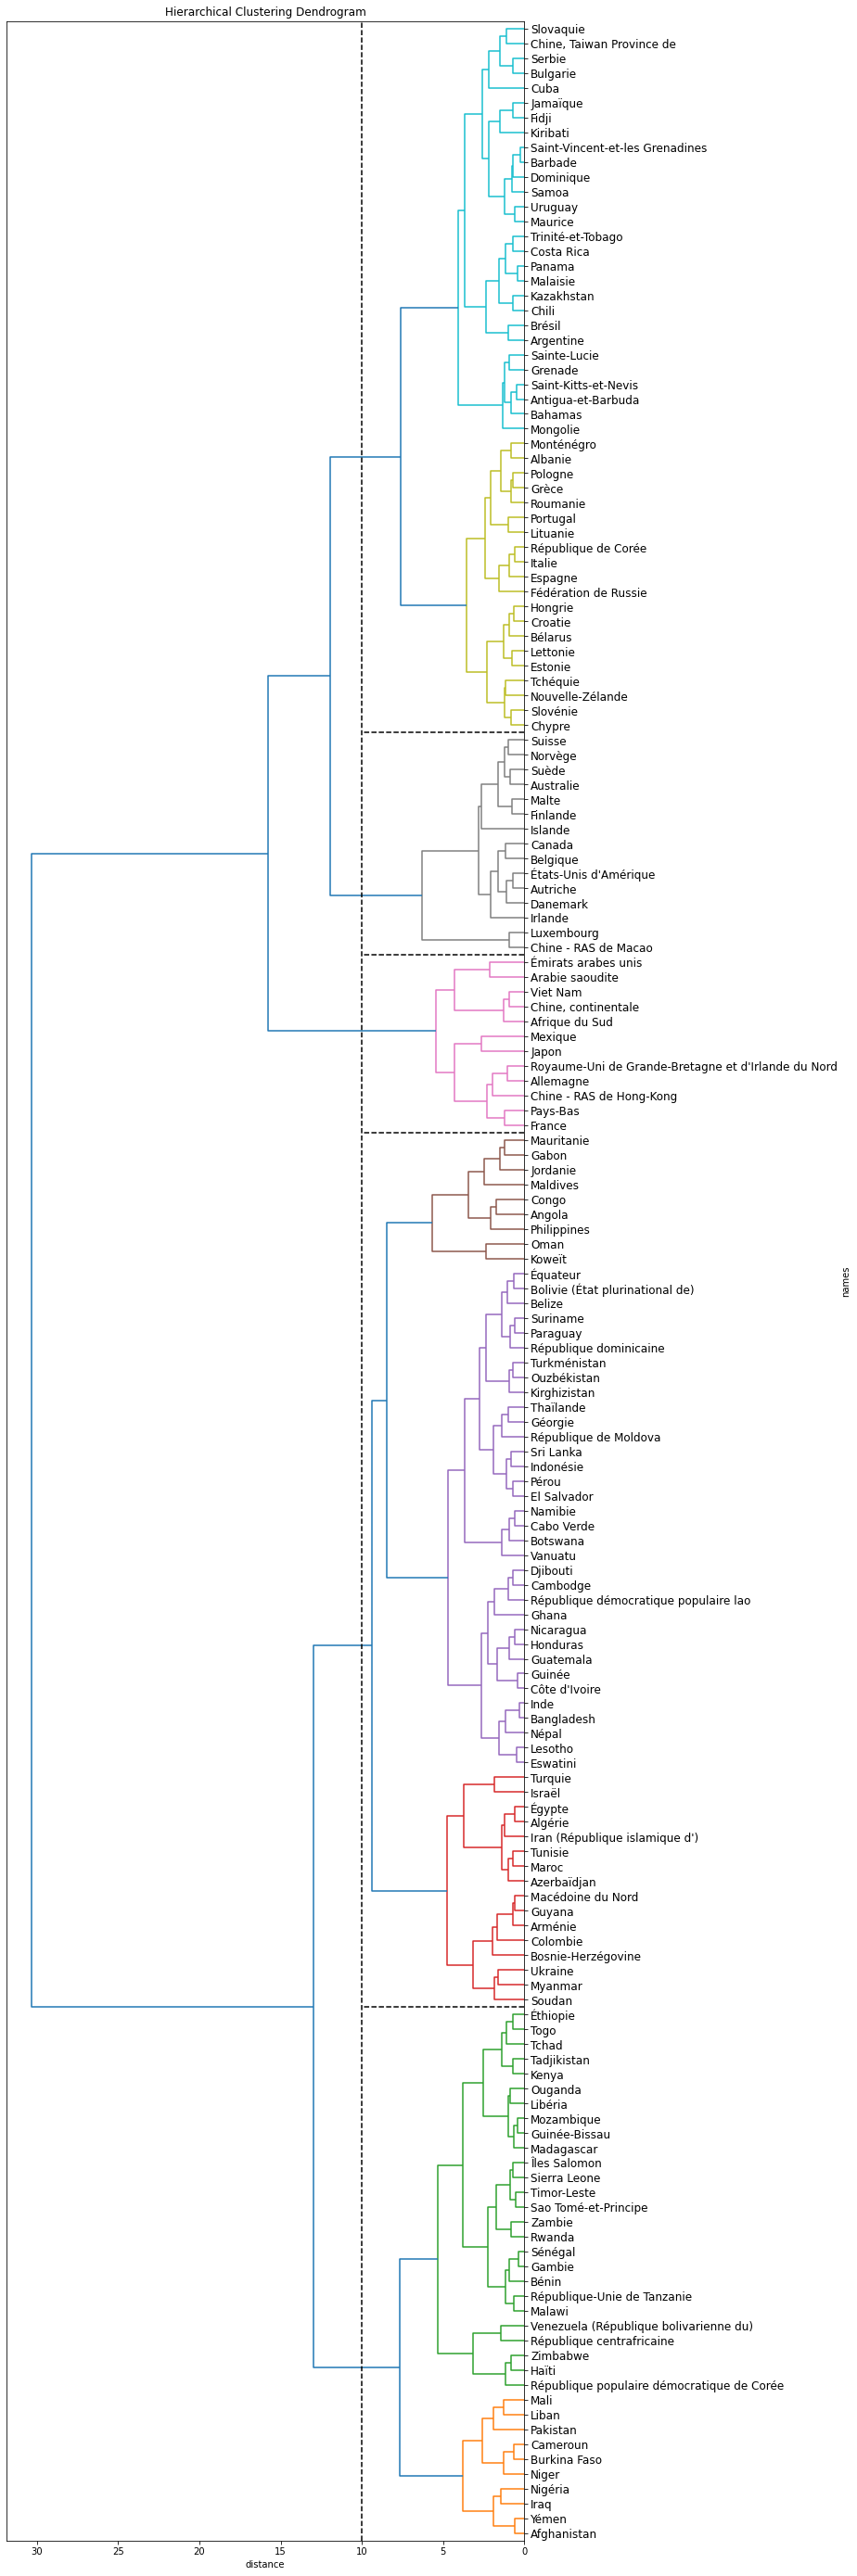

In [10]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import preprocessing
# préparation des données pour le clustering
data=df[["Disponibilité alimentaire (Kcal/personne)","Disponibilité de protéines en quantité (g/personne)","proportion_protéines_animal %","croissance_population %","Stabilité","PIB","Importations - volaille"]]
X=data.values
names= pd.array(df['Zone'])
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')
# Affichage du dendrogramme
fig, ax= plt.subplots(1,1, figsize=(10,50))
ax.set_title('Hierarchical Clustering Dendrogram')
ax.set_xlabel('distance')
ax.set_ylabel('names')
dendrogram(
    Z, 
    orientation = "left",
    leaf_rotation=0.,
    leaf_font_size=12,
    color_threshold=7,
    labels = names
)
ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()
plt.axvline(x= 10, color='k',linestyle='--')
plt.hlines(y=360,xmin=0, xmax=10,linestyle='--')
plt.hlines(y=950,xmin=0, xmax=10,linestyle='--')
plt.hlines(y=1070,xmin=0, xmax=10,linestyle='--')
plt.hlines(y=1220,xmin=0, xmax=10,linestyle='--')
plt.savefig("dendrogram.png",dpi=80, format='png', bbox_inches="tight")

## Coupage du dendrogramme en 5 clusters

In [11]:
clusters = fcluster(Z, 5, criterion='maxclust')
df.loc[:,'clusters'] = fcluster(Z, 5, criterion='maxclust')
cluster=df[['Zone','clusters']]
cluster.to_csv("P5_03_clusters.csv",sep=',', index = False)

## Centroides

In [12]:
centroide=df.groupby(['clusters'])[['Disponibilité alimentaire (Kcal/personne)','Disponibilité de protéines en quantité (g/personne)','proportion_protéines_animal %','croissance_population %','Stabilité','PIB',"Importations - volaille"]].mean().reset_index()
centroide.to_csv("P5_04_centroide.csv",sep=',', index = False) # enregistrer les données d dans un fichiers csv
centroide
# on voit que les disponibilité de protéine sont assez proche mais les clusters 3 et 4 reste les plus élevés et mm au niveu de l'importation (la volaille) cela signfie que ce sont dans ces clusters les pays consomment le plus de protéine

,clusters,Disponibilité alimentaire (Kcal/personne),Disponibilité de protéines en quantité (g/personne),proportion_protéines_animal %,croissance_population %,Stabilité,PIB,Importations - volaille
0,1,8.466783e+05,21401.673611,22.938585,29.069155,-0.937778,3086.458889,21.555556
1,2,1.024802e+06,27880.555932,36.820455,17.715462,-0.405593,11310.323051,41.016949
2,3,1.173019e+06,36880.208333,52.074211,11.363258,0.232500,39512.441667,712.083333
3,4,1.280128e+06,40893.870000,62.675120,10.715674,1.028000,65662.720000,78.466667
4,5,1.125744e+06,33510.954167,55.800886,4.007664,0.584792,24707.425417,58.875000


# Analyse en composantes principales 

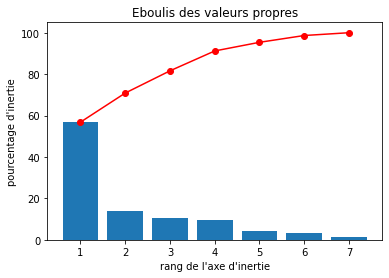

In [13]:
# choix du nombre de composantes à calculer
n_comp =7# min(7,169)
features = data.columns
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)
# Eboulis des valeurs propres
display_scree_plot(pca)
#56.8 % de l’inertie totale sont associés à F1, et 14.1 % à F2, alors le premier plan factoriel représente 70.9 % de l’inertie totale.  

## Cercle des corrélations 

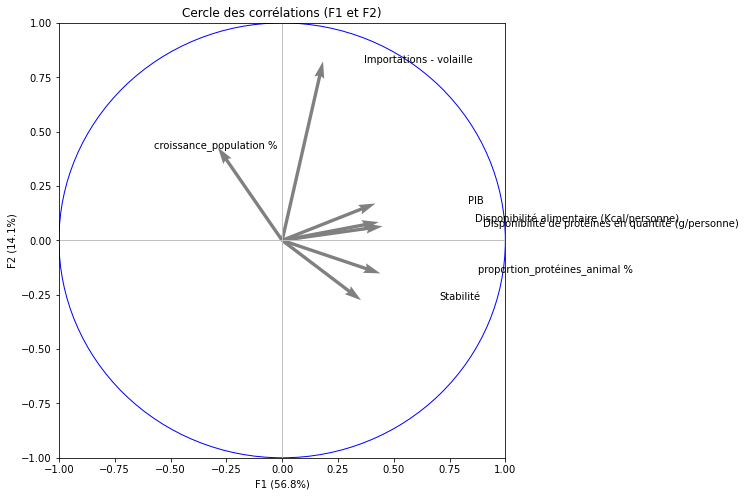

In [14]:
p=7
n=170
#valeur corrigée
eigval = (n-1)/n*pca.explained_variance_
sqrt_eigval = np.sqrt(eigval)
#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
 corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
#cercle des corrélations
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
#affichage des étiquettes (noms des variables)
for j in range(p):
 plt.annotate(data.columns[j],(corvar[j,0],corvar[j,1]))
 #ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)
#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)
#le titre
plt.title("Cercle des corrélations (F{} et F{})".format(0+1, 1+1))
# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(0+1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(1+1, round(100*pca.explained_variance_ratio_[1],1)))
# affichage des flèches
pcs = pca.components_
plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
pcs[0,:], pcs[1,:], 
angles='xy', scale_units='xy', scale=1,color="grey")
#sauvgarder
plt.savefig("cerle.png",dpi=80, format='png', bbox_inches="tight")

## Projection des individus

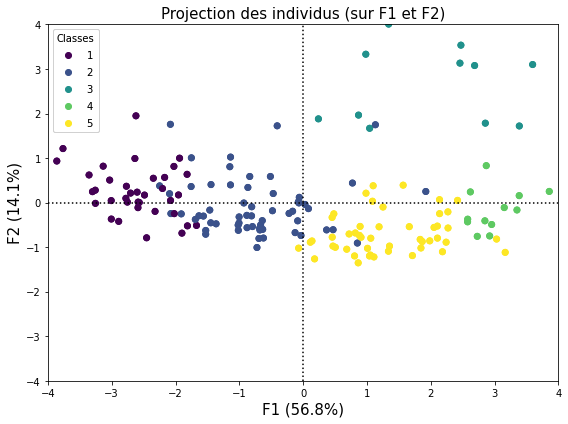

In [15]:
# 
X_projected = pca.transform(X_scaled)
x1=X_projected[:,0]
x2=X_projected[:,1]
y=df.clusters
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
plt.xlim(-4,4)
plt.ylim(-4,4)
ax.set_xlabel ('Composant principal 1', fontsize = 15) 
ax.set_ylabel ('Composant principal 2', fontsize = 15) 
ax.set_title ('Projection des individus (sur F1 et F2)', fontsize = 15)
ax.set_yticks([-4,-3,-2,-1,0, 1, 2,3,4])
plt.scatter(x1,x2,
           c=y,alpha=0.95,edgecolor='face',cmap=plt.cm.get_cmap('viridis',5))
scatter = ax.scatter(x1,x2, c=y)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)
plt.axvline(x= 0, color='k',linestyle=':')
plt.axhline(y=0, color='k',linestyle=':')
# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(0+1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(1+1, round(100*pca.explained_variance_ratio_[1],1)))
plt.savefig("acp.png",dpi=80, format='png', bbox_inches="tight")
# les pays de cluster 3 avec une forte consommation de protéines animales cad  leur habitudes de consommation et la nature de leur régimes alimentaires sont des consommateur de viandes et volailles en plus de ça ils importent des volailles plus de groupe 4 donc ils ont un manque de production.  .

In [16]:
cluster1=df[df['clusters']==1]
cluster2=df[df['clusters']==2]
cluster3=df[df['clusters']==3]
cluster4=df[df['clusters']==4]
cluster5=df[df['clusters']==5]

## visualiser les pays de cluster 3 sur la carte

In [17]:
import folium
France = folium.Map(location = [46.73331437758623, 2.2628415763046648], zoom_start = 4)
folium.Marker([46.73331437758623, 2.2628415763046648], popup = "FRANCE").add_to(France)
ar = np.array([['Afrique du sud',-28.48322,24.676997], ['Allemagne', 51.0834196,10.4234469], ['Arabie saoudite', 25.6242618,42.3528328],['Chine - RAS de Hong-Kong',22.28552,114.15769],['Chine, continentale',35.000074,104.999927],['Japon',36.5748441,139.2394179],['Mexique',22.5000485,-100.0000375],['Pays-Bas',52.5001698,5.7480821],["Royaume-Uni de Grande-Bretagne et d'Irlande du...",54.633221000000006,-3.432277499999998],['Viet Nam',13.2904027,108.4265113],['Émirats arabes unis',24.0002488,53.9994829]])
ff = pd.DataFrame(ar, columns = ['Zone', 'lat', 'long'])
for i in range(0,len(ff)):
    folium.Marker(
    [ff.iloc[i]['lat'],ff.iloc[i]['long']],popup =ff.iloc[i]['Zone']).add_to(France)
France
# on choisit les pays les plus proche de la france pour dépenser moins pour une premieère attaque de marché 
# Pays Bas, Royaume Uni, Allemagne

## Test d'adéquation

### Test de Kolmogorov-Smirnov

In [18]:
from scipy.stats import ks_2samp
ks_2samp(cluster4["proportion_protéines_animal %"],list(np.random.normal(np.mean(cluster4["proportion_protéines_animal %"]), np.std(cluster4["proportion_protéines_animal %"]), 1000)))
#On ne peut donc pas rejetter l’hypothèse de normalité au niveau de test 5%.

KstestResult(statistic=0.113, pvalue=0.9805657707537853)

### Test de shapiro-wilk 

In [19]:
from scipy.stats import shapiro
shapiro(cluster4["proportion_protéines_animal %"])

ShapiroResult(statistic=0.9916999340057373, pvalue=0.9998486042022705)

### Test de Kolmogorov-Smirnov

In [20]:
from scipy.stats import ks_2samp
ks_2samp(cluster5["proportion_protéines_animal %"],list(np.random.normal(np.mean(cluster5["proportion_protéines_animal %"]), np.std(cluster5["proportion_protéines_animal %"]), 1000)))
#On ne peut donc pas rejetter l’hypothèse de normalité au niveau de test 5%.

KstestResult(statistic=0.09683333333333333, pvalue=0.7464090844070168)

### Test de shapiro-wilk

In [21]:
from scipy.stats import shapiro
shapiro(cluster5["proportion_protéines_animal %"])

ShapiroResult(statistic=0.9572524428367615, pvalue=0.07817722111940384)

## Test de comparaison de deux clusters 4 et 5 (dans le cas gaussien)

In [22]:
cl5 = df[df['clusters']==5]["proportion_protéines_animal %"]
cl4 = df[df['clusters']==4]["proportion_protéines_animal %"]

### Test de l'égalité des variances 

In [23]:
from scipy.stats import bartlett
bartlett(cl5,cl4) # on ne rejette pas l’égalité des variances au niveau de test 5%

BartlettResult(statistic=1.7316718676913132, pvalue=0.18819752536537687)

### Test de l'égalité des moyennes

In [24]:
from scipy.stats import ttest_ind
ttest_ind(cl5,cl4, equal_var=True) # on rejete l'égalité des moyennes au niveau de test 5%

Ttest_indResult(statistic=-4.087828635476342, pvalue=0.00012937506851242622)